In [1]:
#ipynb config
import sys
sys.path.append('..')
%load_ext autoreload
%autoreload 2

In [3]:
from sklearn.cross_validation import train_test_split
from models.downsampling_trigger import DownsamplingTrigger
from utils.visualizer import Visualizer
from IPython.display import SVG, display

import numpy as np
import matplotlib.pyplot as plt

import time
import pydot
import lasagne

plt.style.use('ggplot')

%matplotlib notebook

/home/apanin/anaconda/lib/python2.7/site-packages/IPython/kernel/__init__.py:13: ShimWarning: The `IPython.kernel` package has been deprecated. You should import from ipykernel or jupyter_client instead.
  "You should import from ipykernel or jupyter_client instead.", ShimWarning)


In [4]:
def get_hex_color(layer_type):
    """
    Determines the hex color for a layer.
    :parameters:
        - layer_type : string
            Class name of the layer
    :returns:
        - color : string containing a hex color for filling block.
    """
    COLORS = ['#4A88B3', '#98C1DE', '#6CA2C8', '#3173A2', '#17649B',
              '#FFBB60', '#FFDAA9', '#FFC981', '#FCAC41', '#F29416',
              '#C54AAA', '#E698D4', '#D56CBE', '#B72F99', '#B0108D',
              '#75DF54', '#B3F1A0', '#91E875', '#5DD637', '#3FCD12']

    hashed = int(hash(layer_type)) % 5

    if "conv" in layer_type.lower():
        return COLORS[:5][hashed]
    if layer_type in lasagne.layers.pool.__all__:
        return COLORS[5:10][hashed]
    if layer_type in lasagne.layers.recurrent.__all__:
        return COLORS[10:15][hashed]
    else:
        return COLORS[15:20][hashed]

def make_pydot_graph(layers, output_shape=True, verbose=False):
    """
    :parameters:
        - layers : list
            List of the layers, as obtained from lasagne.layers.get_all_layers
        - output_shape: (default `True`)
            If `True`, the output shape of each layer will be displayed.
        - verbose: (default `False`)
            If `True`, layer attributes like filter shape, stride, etc.
            will be displayed.
    :returns:
        - pydot_graph : PyDot object containing the graph
    """

    pydot_graph = pydot.Dot('Network', graph_type='digraph')
    pydot_nodes = {}
    pydot_edges = []
    for i, layer in enumerate(layers):
        layer_type = '{0}'.format(layer.__class__.__name__)
        layer_name = layer.name if layer.name is not None else ''
        key = repr(layer)
        label = layer_name + ' ' + layer_type
        color = get_hex_color(layer_type)
        if verbose:
            for attr in ['num_filters', 'num_units', 'ds',
                         'filter_shape', 'stride', 'strides', 'p']:
                if hasattr(layer, attr):
                    label += '\n{0}: {1}'.format(attr, getattr(layer, attr))
            if hasattr(layer, 'nonlinearity'):
                try:
                    nonlinearity = layer.nonlinearity.__name__
                except AttributeError:
                    nonlinearity = layer.nonlinearity.__class__.__name__
                label += '\nnonlinearity: {0}'.format(nonlinearity)

        if output_shape:
            label += '\nOutput shape: {0}'.format(layer.output_shape)

        pydot_nodes[key] = pydot.Node(
            key, label=label, shape='record', fillcolor=color, style='filled')

        if hasattr(layer, 'input_layers'):
            for input_layer in layer.input_layers:
                pydot_edges.append([repr(input_layer), key])

        if hasattr(layer, 'input_layer'):
            pydot_edges.append([repr(layer.input_layer), key])

    for node in pydot_nodes.values():
        pydot_graph.add_node(node)

    for edges in pydot_edges:
        pydot_graph.add_edge(
            pydot.Edge(pydot_nodes[edges[0]], pydot_nodes[edges[1]]))
    return pydot_graph

def iterate_minibatches(inputs, targets, batch_size):
    indices = np.arange(len(inputs))
    np.random.shuffle(indices)
    
    for start_idx in range(0, len(inputs) - batch_size + 1, batch_size):
        excerpt = indices[start_idx:start_idx + batch_size]

        yield inputs[excerpt], targets[excerpt]


def learn(nn,
          dataset,
          watches=['obj',
                   'recall',
                   'precision',
                   'accuracy',
                   'loss',
                   'sub_loss'],
          num_epochs=100,
          batch_size=50):
    '''
        num_epochs - amount of passes through the data
        batch_size - number of samples processed at each function call
        dataset - [X_train, X_val, y_train, y_val]
    '''
    %matplotlib notebook
    
    X_train, X_val, y_train, y_val = dataset
    metrics_template = dict()
    
    metrics_sample = nn.evaluate(X_val[:2], y_val[:2])
    
    for metric_name, _ in metrics_sample.items():
        if metric_name == 'complexity_parts':
            metrics_template[metric_name] = [0] * len(metrics_sample[metric_name])
        else:
            metrics_template[metric_name] = 0
        
    visualizer = Visualizer(num_epochs,
                            metrics_template,
                            watches=watches)
    
    for epoch in range(num_epochs):
        # In each epoch, we do a full pass over the training data:
        start_time = time.time()
        
        train_measurements = dict(metrics_template)
        train_batches = 0

        for batch in iterate_minibatches(X_train, y_train, batch_size):
            inputs, targets = batch
            
            for metric_name, metric in nn.train(inputs, targets).items():
                if metric_name == 'complexity_parts':
                    for j in range(len(metrics_template[metric_name])):
                        train_measurements[metric_name][j] += metric[j]
                else: 
                    train_measurements[metric_name] += metric

            train_batches += 1
            
        for metric_name, metric in train_measurements.items():
            if metric_name == 'complexity_parts':
                for j in range(len(metrics_template[metric_name])):
                    train_measurements[metric_name][j] = metric[j] / train_batches
            else: 
                train_measurements[metric_name] = metric / train_batches

        # And a full pass over the validation data:
        val_measurements = dict(metrics_template)
        val_batches = 0

        for batch in iterate_minibatches(X_val, y_val, batch_size):
            inputs, targets = batch
            
            for metric_name, metric in nn.evaluate(inputs, targets).items():
                if metric_name == 'complexity_parts':
                    for j in range(len(metrics_template[metric_name])):
                        val_measurements[metric_name][j] += metric[j]
                else: 
                    val_measurements[metric_name] += metric

            val_batches += 1
            
        for metric_name, metric in val_measurements.items():
            if metric_name == 'complexity_parts':
                for j in range(len(metrics_template[metric_name])):
                    val_measurements[metric_name][j] = metric[j] / val_batches
            else: 
                val_measurements[metric_name] = metric / val_batches

        print('Epoch {} of {} took {:.3f}s'.format(epoch + 1, num_epochs, time.time() - start_time))
        visualizer.watch(train_measurements, val_measurements)
    visualizer.finish()
    
def draw(network):
    with open('../images/net.svg', 'w') as f:
        g = make_pydot_graph(lasagne.layers.get_all_layers(network))
        f.write(g.create_svg(f='svg'))

    display(SVG(filename='../images/net.svg'))

In [5]:
dataset0 = np.load('../data/not_bright/imgs_0000.npy')
targets0 = np.load('../data/not_bright/masks_0000.npy')
dataset1 = np.load('../data/not_bright/imgs_0000.npy')
targets1 = np.load('../data/not_bright/masks_0000.npy')

dataset = np.stack((dataset0, dataset1))
targets = np.stack((targets0, targets1))

track_targets = targets.copy()
track_targets[track_targets <=0] = 0

In [6]:
X_y = train_test_split(dataset.reshape(-1, 1, 512, 512).astype(np.float32),
                       track_targets.reshape(-1, 1, 512, 512).astype(np.float32))

## load pretrained on big images network

In [22]:
network = DownsamplingTrigger(img_shape=(512, 512),
                              learning_rate=1e-3,
                              c=1e-1,
                              c_complexity=1,
                              c_sub_objs=[1, 1, 1],
                              c_sub_obj_cs=[1e-1, 1e-1, 1e-1],
                              mul=True,
                              pool_sizes=[2, 2, 2, 2],
                              num_filters=[1, 1, 3, 6],
                              filter_sizes=[1, 3, 3, 3],
                              l2_c=1e-3)

In [23]:
network.load('../weights', '3cascades_long_train')

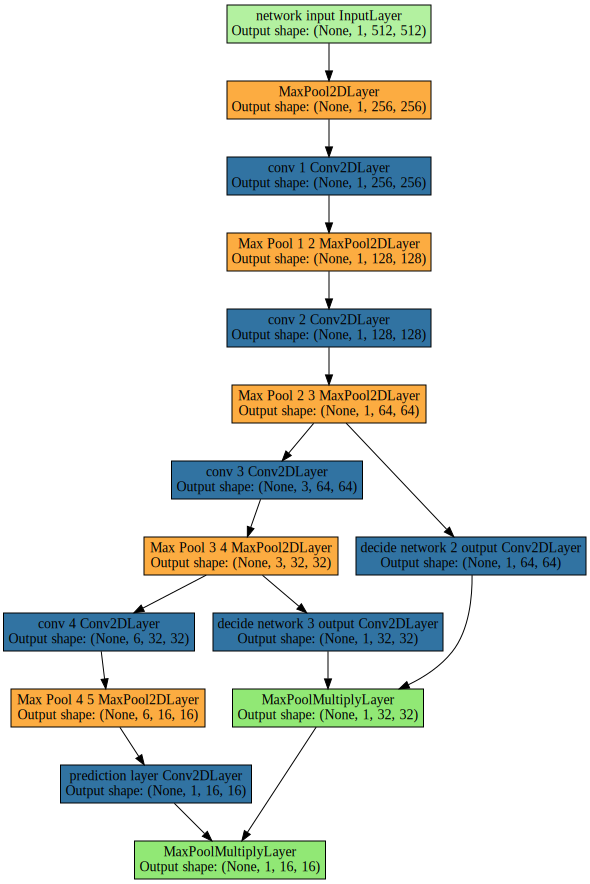

In [24]:
draw(network.output_layer)

<IPython.core.display.Javascript object>


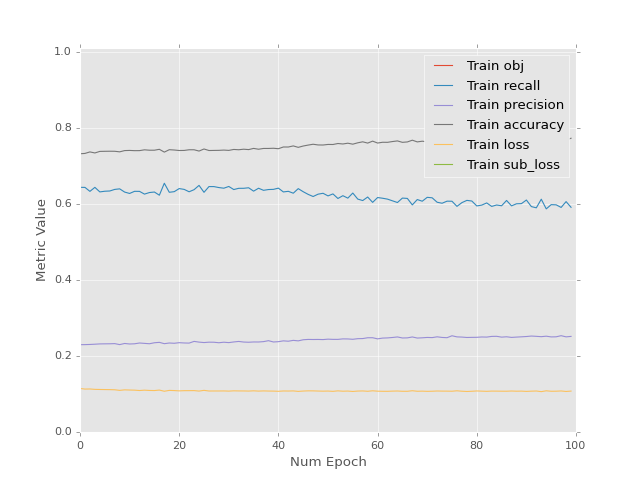

<IPython.core.display.Javascript object>


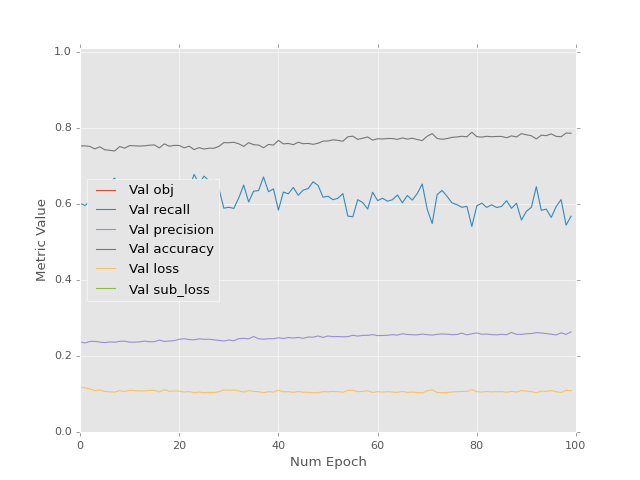

<IPython.core.display.Javascript object>


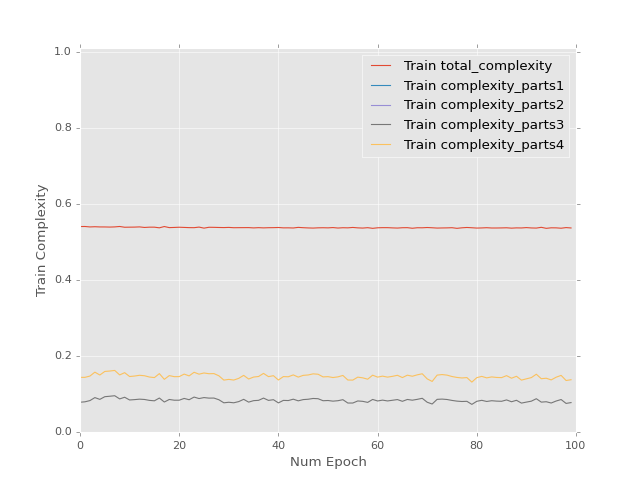

<IPython.core.display.Javascript object>


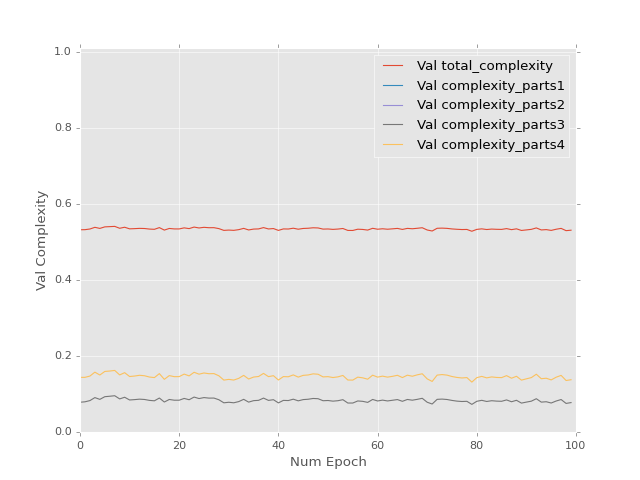

Epoch 1 of 100 took 14.993s


/home/apanin/anaconda/lib/python2.7/site-packages/matplotlib/backends/backend_webagg_core.py:210: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  buff.shape = (renderer.height, renderer.width)


Epoch 2 of 100 took 14.019s
Epoch 3 of 100 took 15.594s
Epoch 4 of 100 took 16.158s
Epoch 5 of 100 took 16.828s
Epoch 6 of 100 took 12.504s
Epoch 7 of 100 took 12.350s
Epoch 8 of 100 took 12.303s
Epoch 9 of 100 took 12.286s
Epoch 10 of 100 took 12.100s
Epoch 11 of 100 took 12.311s
Epoch 12 of 100 took 12.159s
Epoch 13 of 100 took 12.183s
Epoch 14 of 100 took 12.234s
Epoch 15 of 100 took 12.179s
Epoch 16 of 100 took 12.282s
Epoch 17 of 100 took 12.203s
Epoch 18 of 100 took 12.232s
Epoch 19 of 100 took 12.109s
Epoch 20 of 100 took 12.125s
Epoch 21 of 100 took 12.077s
Epoch 22 of 100 took 12.106s
Epoch 23 of 100 took 12.204s
Epoch 24 of 100 took 12.090s
Epoch 25 of 100 took 12.061s
Epoch 26 of 100 took 12.036s
Epoch 27 of 100 took 12.202s
Epoch 28 of 100 took 12.107s
Epoch 29 of 100 took 12.248s
Epoch 30 of 100 took 12.015s
Epoch 31 of 100 took 12.105s
Epoch 32 of 100 took 12.200s
Epoch 33 of 100 took 12.143s
Epoch 34 of 100 took 12.051s
Epoch 35 of 100 took 12.123s
Epoch 36 of 100 took 1

In [25]:
learn(network,
      X_y,
      watches=['obj',
               'recall',
               'precision',
               'accuracy',
               'loss',
               'sub_loss',
               'total_complexity',
               'complexity_parts'],
      num_epochs=100,
      batch_size=50)

# another coefficients

In [26]:
network = DownsamplingTrigger(img_shape=(512, 512),
                              learning_rate=1e-3,
                              c=1e-1,
                              c_complexity=0,
                              c_sub_objs=[1e-2, 1e-1, 1],
                              c_sub_obj_cs=[1e-2, 1e-1, 1e-1],
                              mul=True,
                              pool_sizes=[2, 2, 2, 2],
                              num_filters=[1, 1, 3, 6],
                              filter_sizes=[1, 3, 3, 3],
                              l2_c=1e-3)

In [27]:
network.load('../weights', '3cascades_long_train')

<IPython.core.display.Javascript object>


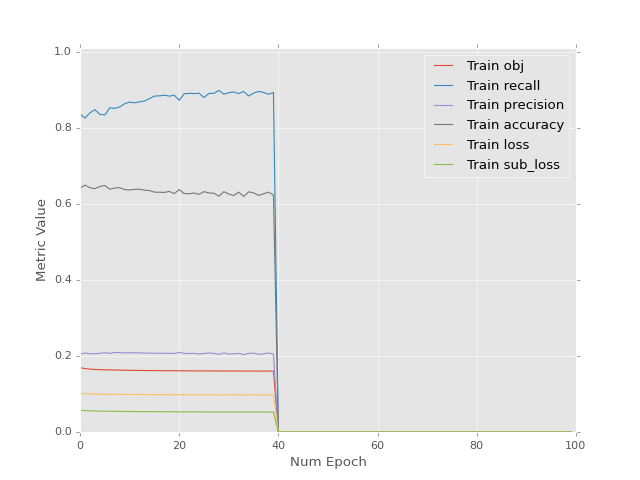

<IPython.core.display.Javascript object>


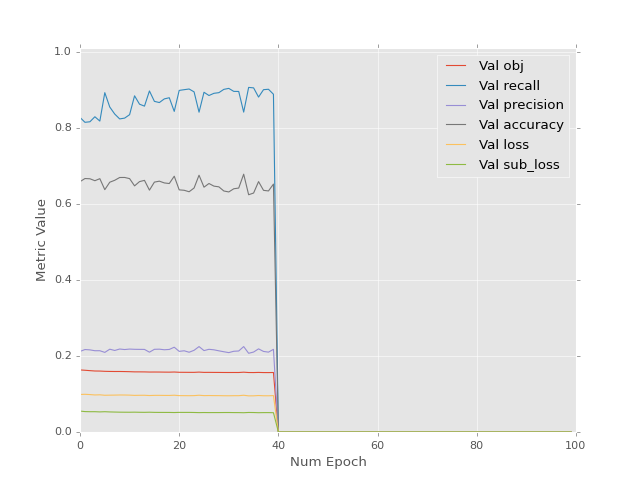

<IPython.core.display.Javascript object>


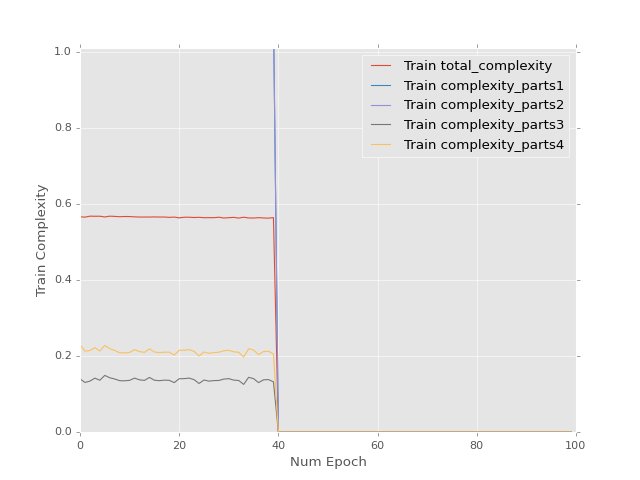

<IPython.core.display.Javascript object>


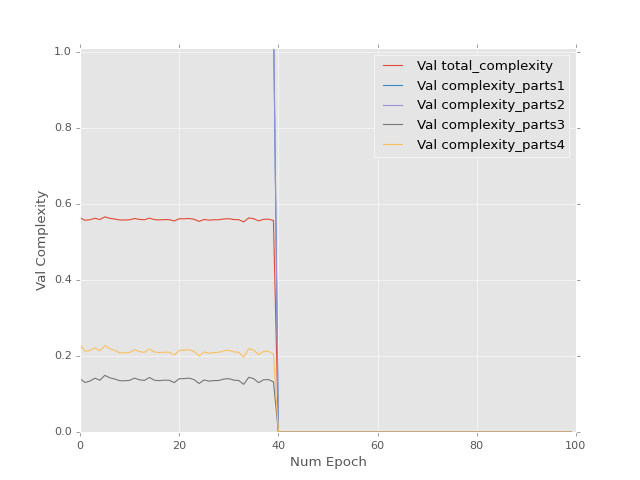

Epoch 1 of 100 took 12.756s
Epoch 2 of 100 took 12.416s
Epoch 3 of 100 took 12.045s
Epoch 4 of 100 took 11.737s
Epoch 5 of 100 took 11.954s
Epoch 6 of 100 took 11.735s
Epoch 7 of 100 took 11.974s
Epoch 8 of 100 took 11.825s
Epoch 9 of 100 took 12.358s
Epoch 10 of 100 took 12.011s
Epoch 11 of 100 took 11.972s
Epoch 12 of 100 took 12.257s
Epoch 13 of 100 took 12.038s
Epoch 14 of 100 took 12.165s
Epoch 15 of 100 took 12.210s
Epoch 16 of 100 took 11.843s
Epoch 17 of 100 took 12.148s
Epoch 18 of 100 took 12.166s
Epoch 19 of 100 took 12.187s
Epoch 20 of 100 took 12.059s
Epoch 21 of 100 took 12.137s
Epoch 22 of 100 took 12.007s
Epoch 23 of 100 took 12.045s
Epoch 24 of 100 took 12.026s
Epoch 25 of 100 took 12.286s
Epoch 26 of 100 took 12.048s
Epoch 27 of 100 took 12.014s
Epoch 28 of 100 took 12.312s
Epoch 29 of 100 took 12.078s
Epoch 30 of 100 took 11.858s
Epoch 31 of 100 took 12.232s
Epoch 32 of 100 took 12.129s
Epoch 33 of 100 took 12.108s
Epoch 34 of 100 took 12.258s
Epoch 35 of 100 took 11

In [ ]:
learn(network,
      X_y,
      watches=['obj',
               'recall',
               'precision',
               'accuracy',
               'loss',
               'sub_loss',
               'total_complexity',
               'complexity_parts'],
      num_epochs=100,
      batch_size=50)